In [64]:
import pandas as pd
import numpy as np
import toad

In [65]:
data = pd.read_csv('test.csv')
print('Shape:',data.shape)
data.head(10)

Shape: (500, 7)


,A,B,C,D,E,F,target
0,0.417022,87,0.154276,0.383389,NaN,84.100880,0
1,0.720324,57,0.758797,0.769808,NaN,74.668182,1
2,0.000114,24,0.197145,-0.105166,NaN,7.504475,0
3,0.302333,55,0.442048,0.300465,NaN,46.824730,1
4,0.146756,49,0.399363,0.096637,NaN,45.993059,1
5,0.092339,52,0.045981,-0.022774,NaN,50.068966,1
6,0.186260,24,0.322268,-0.039216,NaN,37.597628,0
7,0.345561,15,0.311033,0.412043,NaN,26.698194,1
8,0.396767,67,0.393938,0.435124,NaN,56.782580,0
9,0.538817,73,0.407933,0.509187,NaN,71.328520,0


In [66]:
data.loc[:400, 'tag']='train'
data.loc[400:, 'tag']='test'


In [67]:
train=data[:400]
OOT=data[400:]

In [68]:
data_tr_target = data


# 特征初步挑选
selected_data, drop_lst = toad.selection.select(data_tr_target, target = 'target', empty = 0.7, iv = 0.03, corr = 0.7, return_drop=True, exclude = ['tag'])
# feature_cols = list(set(feature_cols) - set(selected_data.columns))
feature_cols = list(set(selected_data.columns) - set(['target'] ) - set(['tag', 'REPAY_TIME']) )
print('初步挑选字段', feature_cols[:5])

初步挑选字段 ['D', 'F']


In [69]:
selected_data.groupby('tag')['target'].agg(['count', 'mean'])

,count,mean
tag,,
test,100,0.4700
train,400,0.5025


In [70]:
from toad.plot import bin_plot
c = toad.transform.Combiner()
to_drop=[]
c.fit(data_tr_target.drop(to_drop, axis=1), y = 'target', method = 'chi', min_samples = 0.05) 

# print(c.export())

In [71]:
transer = toad.transform.WOETransformer()
# combiner.transform() & transer.fit_transform() 转化训练数据，并去掉target列
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['target'], exclude=['target'])
OOT_woe = transer.transform(c.transform(OOT))


In [72]:
card = toad.scorecard.ScoreCard(combiner = c, transer = transer, base_score=850, base_odds=20, pdo=50)
c.fit(train_selected.drop(to_drop, axis=1), y = 'target', method = 'chi', min_samples = 0.05) #empty_separate = False
# card.fit(data_tr_woe[feature_cols], data_tr_target['target'])


In [73]:
# 将woe转化后的数据做逐步回归
final_data = toad.selection.stepwise(train_woe,target = 'target', estimator='ols', direction = 'both', criterion = 'aic', exclude = to_drop)
# 将选出的变量应用于test/OOT数据
final_OOT = OOT_woe[final_data.columns]
print(final_data.shape) # 逐步回归从31个变量中选出了10个

(400, 2)


In [74]:
cols = list(final_data.drop(to_drop+['target'],axis=1).columns)

In [75]:
# 用逻辑回归建模
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(final_data[cols], final_data['target'])

# 预测训练和OOT
# pred_train = lr.predict_proba(final_data.loc[final_data.tag=='train'][col])[:,1]
# pred_OOT = lr.predict_proba(final_OOT.loc[final_OOT.tag=='test'][col])[:,1]

pred_train = lr.predict_proba(final_data[cols])[:,1]
pred_OOT = lr.predict_proba(final_OOT[cols])[:,1]

In [76]:
from toad.metrics import KS, AUC

print('train KS',KS(pred_train, final_data['target']))
print('train AUC',AUC(pred_train, final_data['target']))
#test set
# print('test KS',KS(pred_OOT, final_OOT.loc[final_OOT.tag == 'test','target']))
# print('test AUC',AUC(pred_OOT, final_OOT.loc[final_OOT.tag == 'test','target']))
print('test KS',KS(pred_OOT, final_OOT['target'] ) )
print('test AUC',AUC(pred_OOT, final_OOT['target'] ))

train KS 0.09800245006125154
train AUC 0.5527263181579539
test KS 0.13729425933360095
test AUC 0.4851465274989964


In [77]:
iv_df = toad.quality(final_data[cols], target = final_data['target'], iv_only=True)
iv_df

,iv,gini,entropy,unique
D,0.062146,NaN,NaN,3.0


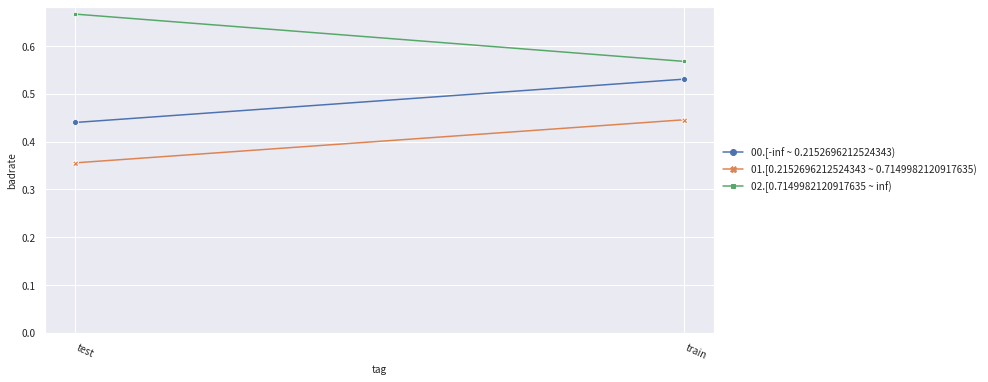

In [78]:
from toad.plot import badrate_plot
# cols.remove('REPAY_TIME') 
peroid = 'tag'
def plot_bin(cols):    
    for col in iv_df.index:
        badrate_plot(c.transform(data_tr_target[[col,'target',peroid]], labels=True), target='target', x='tag', by=col)
plot_bin(cols)

In [ ]:
print('as you can see , NO col in the axis on the righ, only bins')